Epoch     0, Loss: 0.784040
Epoch  1000, Loss: 0.000099
Epoch  2000, Loss: 0.000026
Epoch  3000, Loss: 0.000007
Epoch  4000, Loss: 0.000005
Epoch  5000, Loss: 0.000004
Epoch  6000, Loss: 0.000004
Epoch  7000, Loss: 0.000053
Epoch  8000, Loss: 0.000004
Epoch  9000, Loss: 0.000004


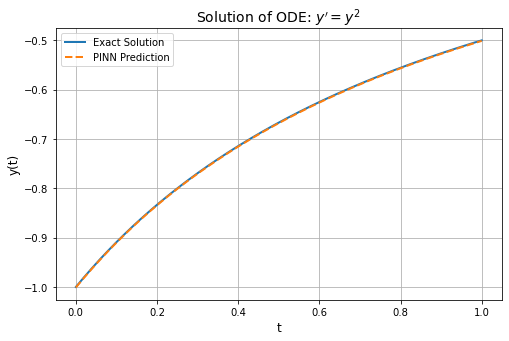

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the Physics-Informed Neural Network (PINN)
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),    # Input layer: time t (dimension 1)
            nn.Tanh(),           # Activation function
            nn.Linear(20, 20),   # Hidden layer
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)     # Output layer: y(t) (dimension 1)
        )
    
    def forward(self, t):
        return self.net(t)

# Compute the loss function
def compute_loss(model, t_ode, t_initial):
    # Initial condition loss (y = -1 when t = 0)
    y_initial = model(t_initial)
    loss_initial = torch.mean((y_initial + 1)**2)  # Analytical solution: y(0) = -1
    
    # ODE residual loss (y' - y^2)
    y_ode = model(t_ode)
    # Compute dy/dt (must ensure t_ode.requires_grad=True)
    dydt = torch.autograd.grad(
        outputs=y_ode,
        inputs=t_ode,
        grad_outputs=torch.ones_like(y_ode),
        create_graph=True,       # Keep the computation graph for higher-order derivatives
        retain_graph=True        # Retain the graph to avoid memory release
    )[0]
    residual = dydt - y_ode**2   # Differential equation residual
    loss_ode = torch.mean(residual**2)
    
    return loss_initial + loss_ode

# Training setup
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10000

# Training loop
for epoch in range(epochs):
    # Enable gradient tracking when generating input tensors
    t_ode = torch.rand(600, 1, requires_grad=True)  # Key: set requires_grad=True
    t_initial = torch.zeros(1, 1, requires_grad=True)
    
    optimizer.zero_grad()
    loss = compute_loss(model, t_ode, t_initial)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f'Epoch {epoch:5d}, Loss: {loss.item():.6f}')

# Testing and visualization
t_test = torch.linspace(0, 1, 600).view(-1, 1)
with torch.no_grad():
    y_pred = model(t_test).numpy()
y_exact = -1 / (1 + t_test.numpy())
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
plt.figure(figsize=(8,5))
plt.plot(t_test.numpy(), y_exact, label='Exact Solution', linewidth=2)
plt.plot(t_test.numpy(), y_pred, '--', label='PINN Prediction', linewidth=2)
plt.xlabel('t', fontsize=12)
plt.ylabel('y(t)', fontsize=12)
plt.title('Solution of ODE: $y\' = y^2$', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_exact = y_exact.reshape(-1, 1)
y_p_pinn = y_pred
y_true = y_exact
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

R2_pinn: 0.9999451343155362, mae_pinn: 0.0010349189396947622, rmse_pinn: 0.00103728286921978, inf_norm_pinn: 0.0011300444602966309


In [4]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': t_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})

data_to_save.to_csv('pinn_05.csv', index=False)
print("pinn_05.csv")

数据已保存至 pinn_05.csv
